## **Utility Code**

Mount The drive

In [1]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


check your GPU

In [ ]:
!nvidia-smi

Mon May 15 07:24:21 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P8     9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

Patchify and segmentation-models

In [3]:
!pip install patchify
!pip install segmentation-models

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 7.3 MB/s eta 0:00:00


In [ ]:
!wget -P "/content/drive/MyDrive/zip_data" https://zenodo.org/record/5706578/files/Test.zip?download=1
!wget -P "/content/drive/MyDrive/LoveDA/dataset" https://zenodo.org/record/5706578/files/Train.zip?download=1
!wget -P "/content/drive/MyDrive/LoveDA/dataset" https://zenodo.org/record/5706578/files/Val.zip?download=1

In [ ]:
!wget -P "/content/drive/MyDrive/zip_data" https://zenodo.org/record/5706578/files/Test.zip?download=1

--2023-05-15 07:59:41--  https://zenodo.org/record/5706578/files/Test.zip?download=1
Resolving zenodo.org (zenodo.org)... 188.185.124.72
Connecting to zenodo.org (zenodo.org)|188.185.124.72|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3126023212 (2.9G) [application/octet-stream]
Saving to: ‘/content/drive/MyDrive/zip_data/Test.zip?download=1’

Test.zip?download=1 100%[===================>]   2.91G  8.89MB/s    in 8m 8s   

2023-05-15 08:07:53 (6.11 MB/s) - ‘/content/drive/MyDrive/zip_data/Test.zip?download=1’ saved [3126023212/3126023212]



In [ ]:
!wget -P "/content/drive/MyDrive/LoveDA/dataset" https://zenodo.org/record/5706578/files/Train.zip?download=1

--2023-05-15 07:28:35--  https://zenodo.org/record/5706578/files/Train.zip?download=1
Resolving zenodo.org (zenodo.org)... 188.185.124.72
Connecting to zenodo.org (zenodo.org)|188.185.124.72|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4021669263 (3.7G) [application/octet-stream]
Saving to: ‘/content/drive/MyDrive/LoveDA/dataset/Train.zip?download=1’

Train.zip?download= 100%[===================>]   3.75G  36.6MB/s    in 3m 25s  

2023-05-15 07:32:01 (18.7 MB/s) - ‘/content/drive/MyDrive/LoveDA/dataset/Train.zip?download=1’ saved [4021669263/4021669263]



In [ ]:
!unzip -uq "/content/drive/MyDrive/LoveDA/dataset/Test.zip" -d "/content/sample_data/"

In [4]:
!unzip -uq "/content/drive/MyDrive/LoveDA/dataset/Train.zip" -d "/content/sample_data/"
!unzip -uq "/content/drive/MyDrive/LoveDA/dataset/Val.zip" -d "/content/sample_data/"
!unzip -uq "/content/drive/MyDrive/LoveDA/dataset/Test.zip" -d "/content/sample_data/"

In [ ]:
!unzip -uq "/content/drive/MyDrive/LoveDA/dataset/Test.zip" -d "/content/sample_data/"

In [ ]:
!unzip -uq "/content/drive/MyDrive/model_resnet_backbone_200images_160epocs_aug.h5.zip" -d "/content/drive/MyDrive/"

# Main Code

Imports

In [5]:
import os
import cv2
from matplotlib import pyplot as plt
import numpy as np
from patchify import patchify
from PIL import Image
import tensorflow as tf
# import tensorflow.keras
import tensorflow.keras
import segmentation_models as sm
from tensorflow.keras.metrics import MeanIoU
from sklearn.preprocessing import MinMaxScaler, StandardScaler
scaler = MinMaxScaler()
from keras.utils import Sequence
from keras.utils import to_categorical
import random

Segmentation Models: using `keras` framework.


If Tensorflow can detect GPU

In [6]:
device_name=tf.test.gpu_device_name()  
if device_name!='/device:GPU:0':
  raise SystemError( 'GPU device not found' )
print(" Found GPU at: {}".format (device_name) )

 Found GPU at: /device:GPU:0


Set the directory

In [7]:
main_dir="/content/drive/MyDrive/LoveDA_dataset/dataset/"
best_dir="/content/sample_data/"
patch_size = 256

Given dataset has mask values in range 0-7 which is very difficult to visualise. So given are the Helper functions

In [8]:
color_scheme=[(int("FF",16),int("FF",16),int("CC",16)),
              (int("9B",16),int("9B",16),int("9B",16)),
              (int("3C",16),int("10",16),int("98",16)),
              (int("66",16),int("00",16),int("CC",16)),
              (int("14",16),int("51",16),int("6C",16)),
              (int("C7",16),int("41",16),int("41",16),),
              (int("2D",16),int("6F",16),int("30",16),),
              (int("6A",16),int("55",16),int("50",16))]
def show_mask(img):
  output=np.zeros(img.shape,dtype=np.uint8)
  for i in range(img.shape[0]):
    for j in range(img.shape[1]):
      for k in range(img.shape[2]):
        # print(img[i,j,0])
        # break
        output[i,j,k]=color_scheme[img[i,j,0]][k]
  return output

Check If you can navigate in dataset and can use Helper functions

/content/sample_data/Train/Rural/masks_png/158.png
(1024, 1024, 3)
(1024, 1024, 3)


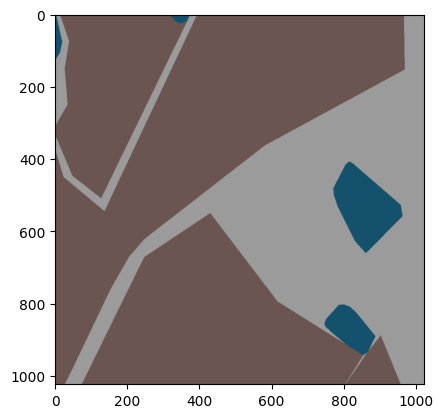

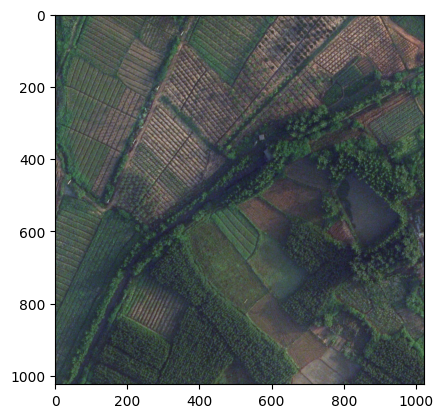

In [9]:
rel_path="Train/Rural/masks_png/158.png"
print(best_dir+rel_path)
img=cv2.imread(best_dir+rel_path)
img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
print(img.shape)
plt.figure()
plt.imshow(show_mask(img))

plt.figure()
img=cv2.imread(best_dir+"Train/Rural/images_png/158.png")
img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
print(img.shape)
plt.imshow(img)

Define Jacard Coefficient Function

In [10]:
from keras import backend as K
def jacard_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (intersection + 1.0) / (K.sum(y_true_f) + K.sum(y_pred_f) - intersection + 1.0)


Dataset_generator Definition

In [11]:
from keras.preprocessing.image import ImageDataGenerator
class CustomImageDataGenerator(Sequence):
    def __init__(self, root_directory, batch_size, input_shape, patch_size,data_augmentation):
        self.root_directory = root_directory
        self.batch_size = batch_size
        self.input_shape = input_shape
        self.patch_size = patch_size
        self.image_files = []
        self.mask_files = []
        self.data_augmentation=data_augmentation
        self.b_sz=int(self.batch_size//((self.input_shape[0]*self.input_shape[0])/(self.patch_size*self.patch_size)))
        if self.data_augmentation:
            self.datagen = ImageDataGenerator(rotation_range=45,
                                              width_shift_range=0.1,
                                              height_shift_range=0.1,
                                              zoom_range=0.2,
                                              horizontal_flip=True,
                                              vertical_flip=True,
                                              fill_mode='constant',
                                              cval=0)
        for path, subdirs, files in os.walk(root_directory):
            dirname = path.split(os.path.sep)[-1]
            if dirname == 'images_png':
                images = os.listdir(path)
                for image_name in images:
                    if image_name.endswith(".png"):
                        self.image_files.append(os.path.join(path, image_name))
            elif dirname == 'masks_png':
                masks = os.listdir(path)
                for mask_name in masks:
                    if mask_name.endswith(".png"):
                        self.mask_files.append(os.path.join(path, mask_name))
        self.image_files.sort()
        self.mask_files.sort()

        my_inds=list(range(len(self.image_files)))
        random.shuffle(my_inds)
        self.image_files = [self.image_files[i] for i in my_inds]
        self.mask_files = [self.mask_files[i] for i in my_inds]

        self.image_files=self.image_files[0:2400:6] #testing for small data
        self.mask_files=self.mask_files[0:2400:6]#testing for small data
    def __len__(self):
        return int(np.floor(len(self.image_files)*((self.input_shape[0]*self.input_shape[1])/(self.patch_size*self.patch_size)) / float(self.batch_size)))

    def __getitem__(self, idx):
        batch_x = self.image_files[idx * self.b_sz:(idx + 1) * self.b_sz]
        batch_y = self.mask_files[idx * self.b_sz:(idx + 1) * self.b_sz]
        images = []
        masks = []
        for i in range(len(batch_x)):
            image = cv2.imread(batch_x[i])
            image=cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
            mask = cv2.imread(batch_y[i])
            mask=cv2.cvtColor(mask,cv2.COLOR_BGR2RGB)
            # SIZE_X = (image.shape[1]//self.patch_size)*self.patch_size
            # SIZE_Y = (image.shape[0]//self.patch_size)*self.patch_size
            # # SIZE_X=patch_size
            # # SIZE_Y=patch_size
            # image = Image.fromarray(image)
            # image = image.crop((0 ,0, SIZE_X, SIZE_Y))  #Crop from top left corner
            #image = image.resize((SIZE_X, SIZE_Y))  #Try not to resize for semantic segmentation
            image = np.array(image)             
            #Extract patches from each image
            # print("Now patchifying image:", path+"/"+image_name)
            patches_img = patchify(image, (self.patch_size, self.patch_size, 3), step=self.patch_size)  #Step=256 for 256 patches means no overlap
            # print(patches_img.shape)
            seed = np.random.randint(0, 2147483647)
            for i in range(patches_img.shape[0]):
                for j in range(patches_img.shape[1]):
                    
                    single_patch_img = patches_img[i,j,:,:]
                    
                    #Use minmaxscaler instead of just dividing by 255. 
                    # single_patch_img = scaler.fit_transform(single_patch_img.reshape(-1, single_patch_img.shape[-1])).reshape(single_patch_img.shape)
                    
                    single_patch_img = (single_patch_img.astype('float32')) / 255. 
                    single_patch_img = single_patch_img[0] #Drop the extra unecessary dimension that patchify adds.
                    single_patch_img=np.array(single_patch_img)                               
                    if self.data_augmentation:
                        single_patch_img= self.datagen.random_transform(single_patch_img, seed=seed)
                    images.append(single_patch_img)
            
            # mask = Image.fromarray(mask)
            # mask = mask.crop((0 ,0, SIZE_X, SIZE_Y))  #Crop from top left corner
            mask = np.array(mask)             
            #Extract patches from each image
            # print("Now patchifying mask:", path+"/"+mask_name)
            patches_mask = patchify(mask, (self.patch_size, self.patch_size, 3), step=self.patch_size)  #Step=256 for 256 patches means no overlap
    
            for i in range(patches_mask.shape[0]):
                for j in range(patches_mask.shape[1]):
                    
                    single_patch_mask = patches_mask[i,j,:,:]
                    #single_patch_img = (single_patch_img.astype('float32')) / 255. #No need to scale masks, but you can do it if you want
                    single_patch_mask = single_patch_mask[0,:,:,:] #Drop the extra unecessary dimension that patchify adds.    
                    single_patch_mask=np.array(single_patch_mask)
                    if self.data_augmentation:
                        single_patch_mask= self.datagen.random_transform(single_patch_mask, seed=seed)
                    single_patch_mask=single_patch_mask[:,:,0]   
                    single_patch_mask=np.array(single_patch_mask)                    
                    masks.append(single_patch_mask)
        # masks = np.expand_dims(masks, axis=-1)  # add channel dimension to mask
        images=np.array(images)
        masks=np.array(masks)
        masks=np.expand_dims(masks, axis=3)
        masks=to_categorical(masks, num_classes=8)
        return images, masks


In [12]:
train_path=best_dir+"Train/"
train_datagen = CustomImageDataGenerator(root_directory=train_path,
                                   batch_size=64,
                                   input_shape=(1024, 1024, 3),
                                   patch_size=256,
                                   data_augmentation=False)


In [13]:
val_path=best_dir+"Val/"
val_datagen = CustomImageDataGenerator(root_directory=val_path,
                                   batch_size=64,
                                   input_shape=(1024, 1024, 3),
                                   patch_size=256,
                                 data_augmentation=False)

In [14]:
# print(os.listdir(train_path))
print(len(train_datagen))
print(len(val_datagen))

100
69


Sanity check

(64, 256, 256, 3)
(64, 256, 256, 8)
float32
0.8666667


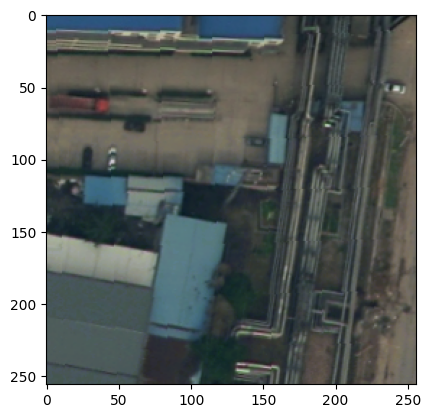

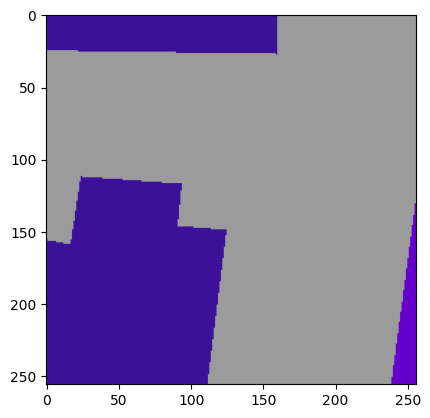

In [15]:
x_batch, y_batch= train_datagen[94]
print(x_batch.shape)
print(y_batch.shape)
i=4
plt.figure()
plt.imshow(x_batch[i])
print(x_batch[i].dtype)
print(np.max(x_batch[i]))
plt.figure()
temp=np.argmax(y_batch[i],axis=-1)
temp1=np.zeros((temp.shape[0],temp.shape[1],3),dtype=np.uint8)
temp1[:,:,0]=temp[:,:]
plt.imshow(show_mask(temp1))

#U-Net Model

In [16]:
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda
from keras import backend as K

################################################################
def multi_unet_model(n_classes=4, IMG_HEIGHT=256, IMG_WIDTH=256, IMG_CHANNELS=1):
#Build the model
    inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
    #s = Lambda(lambda x: x / 255)(inputs)   #No need for this if we normalize our inputs beforehand
    s = inputs

    #Contraction path
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
    c1 = Dropout(0.2)(c1)  # Original 0.1
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)
    
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
    c2 = Dropout(0.2)(c2)  # Original 0.1
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)
     
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
    c3 = Dropout(0.2)(c3)
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)
     
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
    c4 = Dropout(0.2)(c4)
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
    p4 = MaxPooling2D(pool_size=(2, 2))(c4)
     
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
    c5 = Dropout(0.3)(c5)
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)
    
    #Expansive path 
    u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
    c6 = Dropout(0.2)(c6)
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)
     
    u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
    c7 = Dropout(0.2)(c7)
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)
     
    u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
    c8 = Dropout(0.2)(c8)  # Original 0.1
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)
     
    u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
    c9 = Dropout(0.2)(c9)  # Original 0.1
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)
     
    outputs = Conv2D(n_classes, (1, 1), activation='softmax')(c9)
     
    model = Model(inputs=[inputs], outputs=[outputs])
    
    #NOTE: Compile the model in the main program to make it easy to test with various loss functions
    #model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    
    #model.summary()
    
    return model
 

In [17]:
weights = [0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125]
dice_loss = sm.losses.DiceLoss(class_weights=weights) 
focal_loss = sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (1 * focal_loss)  #
metrics=['accuracy', jacard_coef]

IMG_HEIGHT =256
IMG_WIDTH  = 256
IMG_CHANNELS = 3
n_classes=8

In [18]:
def get_model():
    return multi_unet_model(n_classes=n_classes, IMG_HEIGHT=IMG_HEIGHT, IMG_WIDTH=IMG_WIDTH, IMG_CHANNELS=IMG_CHANNELS)

Compile The Model

In [ ]:
model = get_model()
model.compile(optimizer='adam', loss=total_loss, metrics=metrics)
#model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=metrics)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 16  448         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 dropout (Dropout)              (None, 256, 256, 16  0           ['conv2d[0][0]']                 
                                )                                                             

Train The model

In [ ]:
history1 = model.fit(
        train_datagen,
        steps_per_epoch=len(train_datagen),  # number of batches per epoch
        epochs=20,
        validation_data=val_datagen,
        validation_steps=len(val_datagen))

Model Training History



In [ ]:
history = history1
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = history.history['jacard_coef']
val_acc = history.history['val_jacard_coef']

plt.plot(epochs, acc, 'y', label='Training IoU')
plt.plot(epochs, val_acc, 'r', label='Validation IoU')
plt.title('Training and validation IoU')
plt.xlabel('Epochs')
plt.ylabel('IoU')
plt.legend()
plt.show()

Save the Model

In [ ]:
model.save(main_dir+"model_unet_100images_20epochs.h5")

#ResNet Model

Compiling a New Model

In [ ]:
BACKBONE = 'resnet34'
model_resnet_backbone = sm.Unet(BACKBONE, encoder_weights='imagenet', classes=n_classes, activation='softmax')
model_resnet_backbone.compile(optimizer='adam', loss='categorical_crossentropy', metrics=metrics)
print(model_resnet_backbone.summary())


85521592/85521592 [==============================] - 2s 0us/step
Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 data (InputLayer)              [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 bn_data (BatchNormalization)   (None, None, None,   9           ['data[0][0]']                   
                                3)                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, None, None,   0          ['bn_data[0][0]']                
                           

In [20]:
# Model Training
history2=model_resnet_backbone.fit_generator(train_datagen, 
          steps_per_epoch=len(train_datagen), 
          epochs=10,
          validation_data=val_datagen,
          validation_steps=len(val_datagen))
          


<ipython-input-20-c293e3112847>:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history2=model_resnet_backbone.fit_generator(train_datagen,


Epoch 1/10
100/100 [==============================] - 201s 1s/step - loss: 0.8267 - accuracy: 0.6948 - jacard_coef: 0.4134 - val_loss: 1.0354 - val_accuracy: 0.6220 - val_jacard_coef: 0.3404
Epoch 2/10
100/100 [==============================] - 146s 1s/step - loss: 0.7200 - accuracy: 0.7282 - jacard_coef: 0.4536 - val_loss: 1.0610 - val_accuracy: 0.6297 - val_jacard_coef: 0.3570
Epoch 3/10
100/100 [==============================] - 148s 1s/step - loss: 0.6864 - accuracy: 0.7398 - jacard_coef: 0.4744 - val_loss: 1.0493 - val_accuracy: 0.6412 - val_jacard_coef: 0.3735
Epoch 4/10
100/100 [==============================] - 146s 1s/step - loss: 0.6409 - accuracy: 0.7566 - jacard_coef: 0.4951 - val_loss: 1.1508 - val_accuracy: 0.6269 - val_jacard_coef: 0.3514
Epoch 5/10
100/100 [==============================] - 146s 1s/step - loss: 0.5993 - accuracy: 0.7752 - jacard_coef: 0.5197 - val_loss: 1.2202 - val_accuracy: 0.6044 - val_jacard_coef: 0.3516
Epoch 6/10
100/100 [=========================

Model Training History

In [ ]:
history = history2
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = history.history['jacard_coef']
val_acc = history.history['val_jacard_coef']

plt.plot(epochs, acc, 'y', label='Training IoU')
plt.plot(epochs, val_acc, 'r', label='Validation IoU')
plt.title('Training and validation IoU')
plt.xlabel('Epochs')
plt.ylabel('IoU')
plt.legend()
plt.show()  

Save the Model

In [21]:
model_resnet_backbone.save("/content/drive/MyDrive/model_resnet_backbone_200images_170epochs.h5")

Training a Saved Model by loading it again and countinuing the training

Loading the model

In [34]:
from tensorflow.keras.models import load_model
# load model
model_resnet_backbone = load_model("/content/drive/MyDrive/model_resnet_backbone_200images_170epochs.h5",custom_objects={"jacard_coef": jacard_coef })

Train the model

In [ ]:
history2=model_resnet_backbone.fit_generator(train_datagen, 
          steps_per_epoch=len(train_datagen), 
          epochs=20,
          validation_data=val_datagen,
          validation_steps=len(val_datagen))
          

<ipython-input-106-9ab8ae1b9a11>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history2=model_resnet_backbone.fit_generator(train_datagen,


Epoch 1/20
  4/100 [>.............................] - ETA: 3:51 - loss: 2.2563 - accuracy: 0.1780 - jacard_coef: 0.0799

KeyboardInterrupt: ignored

Plot the Model history

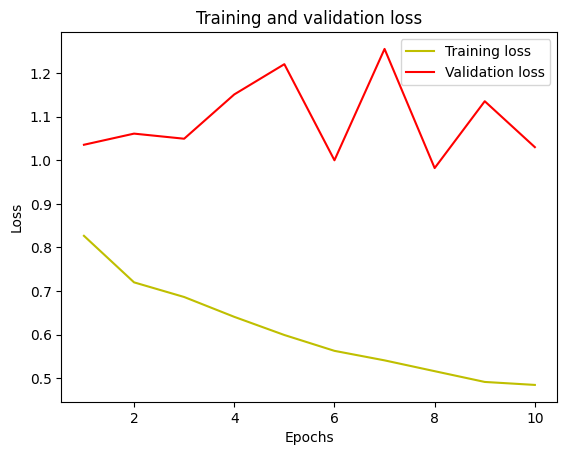

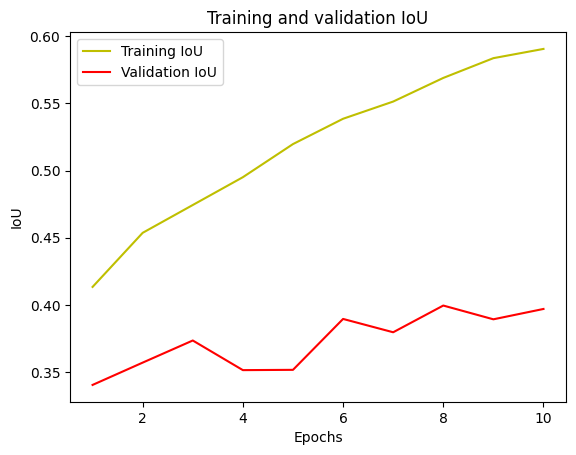

In [33]:
history = history2
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = history.history['jacard_coef']
val_acc = history.history['val_jacard_coef']

plt.plot(epochs, acc, 'y', label='Training IoU')
plt.plot(epochs, val_acc, 'r', label='Validation IoU')
plt.title('Training and validation IoU')
plt.xlabel('Epochs')
plt.ylabel('IoU')
plt.legend()
plt.show()  

Save The model

In [ ]:
# model_resnet_backbone.save("/content/drive/MyDrive/model_resnet_backbone_200images.h5")

# Testing a Model

In [35]:

test_datagen = CustomImageDataGenerator(root_directory=val_path,
                                   batch_size=64,
                                   input_shape=(1024, 1024, 3),
                                   patch_size=256,data_augmentation=False)

1/1 [==============================] - 0s 24ms/step
(256, 256)


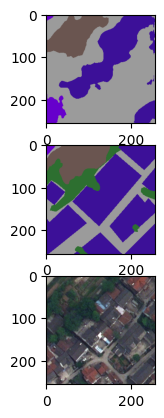

In [38]:
import random
i=random.randint(0,15)
test_img_number = random.randint(0, len(test_datagen)-1)
_x_test,_y_test = test_datagen[test_img_number]
test_img = _x_test[i]
ground_truth=np.argmax(_y_test[i],axis=-1)
test_img_input=np.expand_dims(test_img, 0)
prediction = (model_resnet_backbone.predict(test_img_input))
predicted_img=np.argmax(prediction, axis=-1)[0,:,:]
print(predicted_img.shape)
temp1=np.zeros((predicted_img.shape[0],predicted_img.shape[1],3),dtype=np.uint8)
temp1[:,:,0]=predicted_img[:,:]

fig = plt.figure()
fig.add_subplot(3, 1, 1)
plt.imshow(show_mask(temp1))

temp=np.argmax(_y_test[i],axis=-1)
temp1=np.zeros((temp.shape[0],temp.shape[1],3),dtype=np.uint8)
temp1[:,:,0]=temp[:,:]
fig.add_subplot(3, 1, 2)
plt.imshow(show_mask(temp1))

fig.add_subplot(3, 1, 3)
plt.imshow(test_img)



In [39]:
def predict(model,in_img,patch_size):
  shape=in_img.shape
  prediction_data=[]
  in_img = np.array(in_img)
  patches_img = patchify(in_img, (patch_size,patch_size, 3), step=patch_size)  #Step=256 for 256 patches means no overlap
  for i in range(patches_img.shape[0]):
    for j in range(patches_img.shape[1]):

        single_patch_img = patches_img[i,j,:,:]
        
        #Use minmaxscaler instead of just dividing by 255. 
        # single_patch_img = scaler.fit_transform(single_patch_img.reshape(-1, single_patch_img.shape[-1])).reshape(single_patch_img.shape)
        
        single_patch_img = (single_patch_img.astype('float32')) / 255. 
        single_patch_img = single_patch_img[0] #Drop the extra unecessary dimension that patchify adds.
        single_patch_img=np.array(single_patch_img)
        test_img_input=np.expand_dims(single_patch_img, 0)
        prediction = model_resnet_backbone.predict(test_img_input)
        predicted_img=np.argmax(prediction, axis=-1)[0,:,:] 
        temp1=np.zeros((predicted_img.shape[0],predicted_img.shape[1],3),dtype=np.uint8)
        temp1[:,:,0]=predicted_img[:,:]
        predicted_img=temp1                           
        prediction_data.append(predicted_img)
  prediction_data=np.array(prediction_data)

  output=np.zeros((shape[0],shape[0],prediction_data.shape[-1]),dtype=np.uint8)
  for i in range(shape[0]//patch_size):
      for j in range(shape[1]//patch_size):
         
          output[i*patch_size:(i+1)*patch_size,j*patch_size:(j+1)*patch_size,:]=prediction_data[(i*(shape[0]//patch_size))+j,:,:,:]
  return output




In [40]:
def getpath_img(file_name,root_dir):

  # iterate over all directories and files in the root directory
  for dirpath, dirnames, filenames in os.walk(root_dir):
      # check if the current file matches the desired file name
      cur_dirname=dirpath.split(os.path.sep)[-1]
      if (cur_dirname=='images_png')and(file_name in filenames):
          # construct the path to the file
          file_path = os.path.join(dirpath, file_name)
          # do something with the file_path, for example print it
          return file_path

In [41]:
def getpath_mask(file_name,root_dir):

  # iterate over all directories and files in the root directory
  for dirpath, dirnames, filenames in os.walk(root_dir):
      # check if the current file matches the desired file name
      cur_dirname=dirpath.split(os.path.sep)[-1]
      if (cur_dirname=='masks_png')and(file_name in filenames):
          # construct the path to the file
          file_path = os.path.join(dirpath, file_name)
          # do something with the file_path, for example print it
          return file_path

/content/sample_data/Val/Urban/images_png/3911.png
1/1 [==============================] - 0s 23ms/step
(1024, 1024, 3)


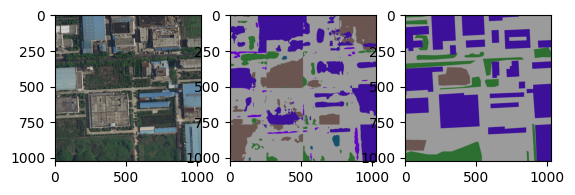

In [48]:
ind=random.randint(2522,4190)
root=best_dir+"Val/"
filename=f"{ind}.png"
img_path=getpath_img(filename,root)
mask_path=getpath_mask(filename,root)
print(img_path)
img=cv2.imread(img_path)
img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
mask=cv2.imread(mask_path)
mask=cv2.cvtColor(mask,cv2.COLOR_BGR2RGB)
p_o1=predict(model_resnet_backbone,img,256)
print(p_o1.shape)

plt.figure()
plt.subplot(1,3,1)
plt.imshow(img)



plt.subplot(1, 3, 2)
plt.imshow(show_mask(p_o1))

plt.subplot(1,3,3)
plt.imshow(show_mask(mask))
